# Metric learning for MIR coding demo (1)

In this notebook, we'll demonstrate how to combine metric learning with nearest neighbor classification, and compare a few standard methods.

Our dataset will be a subset of real instrument recordings from the [NSynth data](https://magenta.tensorflow.org/datasets/nsynth).
Specifically, each example corresponds to a recording of a single note produced by one of the following source families:

- bass
- brass 
- flute
- guitar
- keyboard
- mallet
- organ
- reed
- string
- vocal

For each example, we've pre-computed the time-averaged MFCCs, chroma, and estimated fundamental frequency (f0) with librosa 0.8.
The result is a 26-dimensional feature vector (13 MFCCs, 12 chroma, 1 f0) summarizing each recording.

Our goal here is to learn a nearest neighbor classifier which can accurately infer the instrument family for unseen examples by comparing to our training examples.

The training set consists of 1200 examples (120 for each class), and the test set consists of 200 examples (20 for each class).

In [1]:
# We'll need numpy and pandas for basic data wrangling
import numpy as np
import pandas as pd

# We'll need matplotlib and seaborn for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# We'll use some preprocessing from scikit-learn:
#  Standard scaling (z-scoring) and label encoding
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Our classifier will be 1-nearest-neighbor after learning the distance metric
from sklearn.neighbors import KNeighborsClassifier

# Pipelines make it a little easier to manage sequences of models,
# eg scaler -> metric learner -> 1nn
from sklearn.pipeline import make_pipeline

# We'll use some standard machinery for reporting accuracy of our models
from sklearn.metrics import classification_report,  plot_confusion_matrix

# scikit-learn provides Linear discriminant analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# We'll take NCA and LMNN from the metric_learn package
from metric_learn import NCA, LMNN, ITML_Supervised, SDML_Supervised

# Finally, umap will let us map high-dimensional data down to 2-d for plotting
import umap

# Loading the data

Our features have been pre-computed in a companion notebook `Prep data nsynth.ipynb` included in this repository.
The data had been previously partitioned into train, validation, and test sets.
For our purposes, we'll combine the train and validation data into a single "training set", though you may want to keep them separate if you plan to modify this notebook to do hyper-parameter tuning of the metric learning methods.

In [2]:
# Load in our pre-split dataset
# column 0 corresponds to the filename of the original file, so we'll use as the index
df_train = pd.read_csv('nsynth_train.csv', index_col=0)
df_val = pd.read_csv('nsynth_valid.csv', index_col=0)
df_test = pd.read_csv('nsynth_test.csv', index_col=0)

# Merge train and validation into a single dataframe
df_train = df_train.append(df_val)

## What's in our dataframe?

The dataframe loaded from the CSV files include both features and a label column.
Let's see how it looks

In [3]:
df_train.columns

Index(['mfcc_00', 'mfcc_01', 'mfcc_02', 'mfcc_03', 'mfcc_04', 'mfcc_05',
       'mfcc_06', 'mfcc_07', 'mfcc_08', 'mfcc_09', 'mfcc_10', 'mfcc_11',
       'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17',
       'mfcc_18', 'mfcc_19', 'chroma_00', 'chroma_01', 'chroma_02',
       'chroma_03', 'chroma_04', 'chroma_05', 'chroma_06', 'chroma_07',
       'chroma_08', 'chroma_09', 'chroma_10', 'chroma_11', 'f0', 'instrument'],
      dtype='object')

In [4]:
# Print the first 3 rows
df_train.head(3)

,mfcc_00,mfcc_01,mfcc_02,mfcc_03,mfcc_04,mfcc_05,mfcc_06,mfcc_07,mfcc_08,mfcc_09,...,chroma_04,chroma_05,chroma_06,chroma_07,chroma_08,chroma_09,chroma_10,chroma_11,f0,instrument
train/bass_electronic_000-029-100.wav,-505.147522,71.970406,61.643650,54.583172,45.373104,36.804321,30.121792,23.983734,18.552622,14.097182,...,0.225605,0.921244,0.212651,0.138998,0.071247,0.087334,0.044764,0.046463,86.132812,bass
train/bass_electronic_000-030-100.wav,-493.404175,71.546364,62.092129,55.881756,46.673584,38.422039,31.194138,24.226343,18.617693,13.854385,...,0.102623,0.204708,0.957808,0.231504,0.129417,0.069219,0.044033,0.031961,96.899414,bass
train/bass_electronic_000-031-100.wav,-493.051666,60.773159,53.246670,48.696110,41.951466,35.446091,30.470991,25.491070,20.891851,16.747341,...,0.037824,0.094561,0.256409,0.912336,0.223039,0.080969,0.044021,0.033413,96.899414,bass


In [5]:
df_train.describe()

,mfcc_00,mfcc_01,mfcc_02,mfcc_03,mfcc_04,mfcc_05,mfcc_06,mfcc_07,mfcc_08,mfcc_09,...,chroma_03,chroma_04,chroma_05,chroma_06,chroma_07,chroma_08,chroma_09,chroma_10,chroma_11,f0
count,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,...,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000,1200.000000
mean,-397.952267,72.139837,-14.697081,16.032645,-2.033141,0.643067,-5.193931,-2.747392,-6.970175,-4.924080,...,0.207505,0.207660,0.206035,0.194671,0.202176,0.193769,0.203440,0.190152,0.187023,434.602844
std,92.357817,40.877613,42.914851,20.406139,23.438139,13.813324,14.357595,10.576205,11.380000,10.525304,...,0.240423,0.237312,0.239274,0.229352,0.237021,0.231681,0.237226,0.233008,0.230537,258.468469
min,-792.052551,-19.027298,-121.620178,-29.270638,-56.793819,-40.804161,-40.926208,-30.093281,-36.730377,-34.661007,...,0.010194,0.010091,0.008340,0.007973,0.009424,0.007408,0.006909,0.007910,0.007963,53.833008
25%,-465.926476,41.311467,-53.234385,2.326241,-16.162392,-7.985048,-14.393571,-9.440512,-14.303902,-11.433131,...,0.077198,0.077517,0.076873,0.072985,0.074652,0.069424,0.069664,0.063251,0.059008,236.865234
50%,-386.749146,70.888695,-8.745481,12.694715,-1.602607,-0.088412,-4.481299,-3.798832,-7.283327,-5.789846,...,0.125302,0.127186,0.123616,0.117407,0.125194,0.117590,0.120056,0.103758,0.104557,387.597656
75%,-328.059410,102.177975,13.421279,27.665426,12.092280,7.954888,3.200005,1.914814,-0.655102,-0.196660,...,0.197715,0.201218,0.205845,0.198289,0.199606,0.198423,0.205624,0.188158,0.192933,592.163086
max,-196.869904,211.486816,87.453400,96.740334,60.520569,40.867226,43.739326,49.550674,48.615078,54.358253,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1044.360352


In [6]:
# All but the last column are features
X_train = df_train[df_train.columns[:-1]]
X_test = df_test[df_test.columns[:-1]]

# The last column contains our target label.
# "raw" here indicates that this is the string form of the label,
# which we'll use for printing our system outputs
Y_train_raw = df_train[df_train.columns[-1]]
Y_test_raw = df_test[df_test.columns[-1]]

In [7]:
# Print the unique set of labels in the training data
Y_train_raw.unique()

array(['bass', 'brass', 'flute', 'guitar', 'keyboard', 'mallet', 'organ',
       'reed', 'string', 'vocal'], dtype=object)

In [8]:
# We'll need to use a label encoder to encode our instrument
# names as numeric identifiers (0, 1, 2, ..., 9)
encoder = LabelEncoder()

# "Fit" on the training labels; this is really just specifying our vocabulary
# transform maps the encoding over the list of strings to give our encoded label array
y_train = encoder.fit_transform(Y_train_raw)

# Since the encoder is already fit, we can now transform our test set labels as well
y_test = encoder.transform(Y_test_raw)

In [9]:
print(y_train)

[0 0 0 ... 9 9 9]


Finally, many of the methods we'll use below involve some amount of randomization, if only for parameter initialization.
To ensure that our notebook is reproducible, we'll fix a random number generator (RNG) seed.

In [10]:
RNG_STATE = 2020

---
## Baseline

How well does ordinary nearest neighbors do?

We'll test this by chaining together a feature normalization (`StandardScaler`) with a 1-nearest-neighbor (1NN) classifier.

The feature normalization is a coordinate-wise standardization:

$$
x[d] \mapsto \frac{x[d] - \mu[d]}{\sigma[d]}
$$

where each dimension $d$ is centered by subtracting the mean value $\mu[d]$ and dividing by the standard deviation $\sigma[d]$, both of which are estimated on the training set.
This is a useful pre-processing step for metric learning as well, since it ensures that all features start out contributing equally to the distance calculation.

              precision    recall  f1-score   support

        bass       0.70      0.80      0.74        20
       brass       0.68      0.65      0.67        20
       flute       0.58      0.55      0.56        20
      guitar       0.61      0.70      0.65        20
    keyboard       0.72      0.65      0.68        20
      mallet       0.82      0.90      0.86        20
       organ       0.92      0.55      0.69        20
        reed       0.44      0.20      0.28        20
      string       0.60      0.90      0.72        20
       vocal       0.64      0.80      0.71        20

    accuracy                           0.67       200
   macro avg       0.67      0.67      0.66       200
weighted avg       0.67      0.67      0.66       200



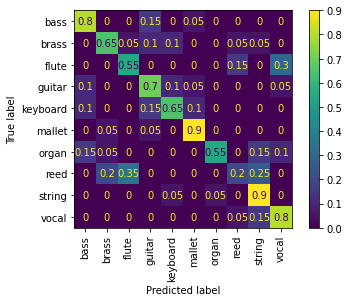

In [11]:
# Our classifier is a "pipeline": scaling followed by KNN
clf = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=1))

# Fit all stages of the pipeline to our training data
clf.fit(X_train, y=y_train)

# How well does our 1-Nearest neighbor model work?
y_pred = clf.predict(X_test)

# Compare our predictions to the true labels in y_test
report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

# Finally, plot a confusion matrix showing how mistakes are distributed
plot_confusion_matrix(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

## Visualizing the data

We can visualize this in two dimensions using [UMAP](https://umap-learn.readthedocs.io/en/latest/) embedding.
UMAP learns a transformation of high-dimensional data (in our case, 32 dimensions) to a low dimensional space which approximately preserves neighborhoods.
The output coordinates do not have any particular meaning, but the local structure of data in the embedding space should give a sense of how well organized the high-dimensional space is.

In [12]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll apply all but the last stage (KNN classifier) of our pipeline to the data.
# In this case, we just have one previous stage, which does feature normalization.
# This will change in subsequent examples.

X_train_transformed = clf[:-1].transform(X_train)
X_test_transformed = clf[:-1].transform(X_test)

# Fit on the transformed data, and then transform the test data
embed = reducer.fit_transform(X_train_transformed)
embed_test = reducer.transform(X_test_transformed)

We'll scatter-plot the training data, indicated by ● markers, and test data, indicated by $\times$ markers.

Each instrument family will get its own color.  If the test and training data of the same color appear near each other in the visualization, then nearest neighbor classification should work well.

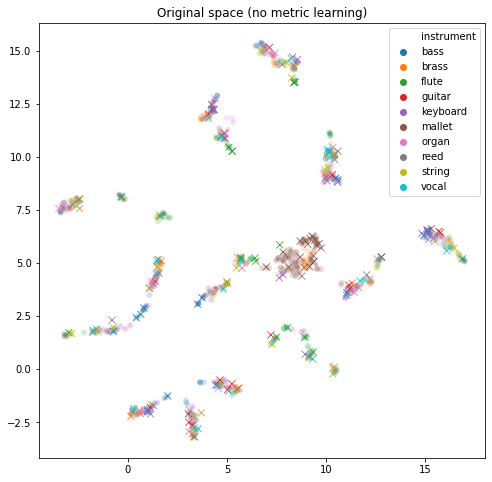

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=Y_train_raw, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=Y_test_raw, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Original space (no metric learning)');

---
## Linear discriminant analysis

The first method we'll try is Linear Discriminant Analysis (LDA) as implemented by scikit-Learn.

Since we have 10 classes, LDA will learn a 9-dimensional projection of the feature space which separates the training data well.

Our steps are much the same as before, except now our pipeline includes an LDA step between the scaler and the classifier.

[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.0s
[Pipeline]  (step 2 of 3) Processing lineardiscriminantanalysis, total=   0.0s
[Pipeline]  (step 3 of 3) Processing kneighborsclassifier, total=   0.0s
              precision    recall  f1-score   support

        bass       0.76      0.95      0.84        20
       brass       1.00      0.80      0.89        20
       flute       0.61      0.55      0.58        20
      guitar       0.75      0.75      0.75        20
    keyboard       0.77      0.50      0.61        20
      mallet       0.87      1.00      0.93        20
       organ       0.93      0.70      0.80        20
        reed       0.62      0.40      0.48        20
      string       0.69      1.00      0.82        20
       vocal       0.71      1.00      0.83        20

    accuracy                           0.77       200
   macro avg       0.77      0.77      0.75       200
weighted avg       0.77      0.77      0.75       200



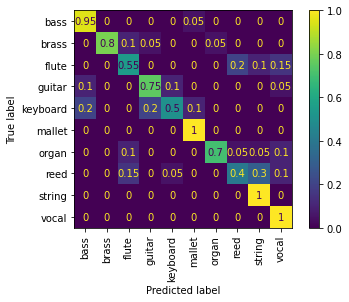

In [14]:
clf = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(), KNeighborsClassifier(n_neighbors=1), verbose=True)
clf.fit(X_train, y=y_train)

y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

plot_confusion_matrix(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

LDA does pretty well, but makes a lot of mistakes on `flute`, `keyboard`, `organ`, and `reed`.

Just like before, we'll visualize this learned transformation with UMAP.

In [15]:
reducer = umap.UMAP(random_state=RNG_STATE)

# We'll fit the umap embedding on the data after applying our learned transformation
embed = reducer.fit_transform(clf[:-1].transform(X_train))
embed_test = reducer.transform(clf[:-1].transform(X_test))

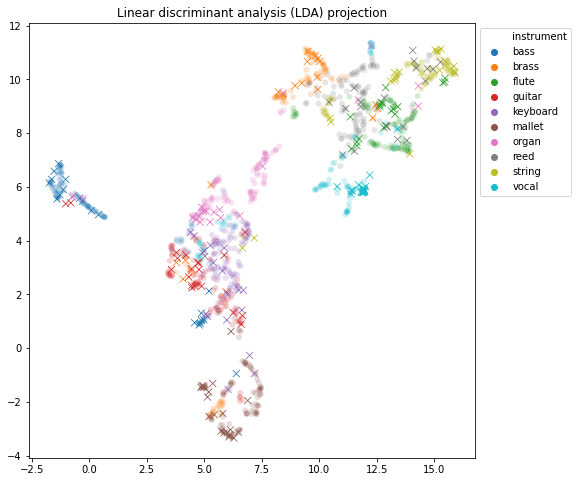

In [16]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=Y_train_raw, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=Y_test_raw, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='Linear discriminant analysis (LDA) projection');

We can also inspect the linear projection learned by LDA.

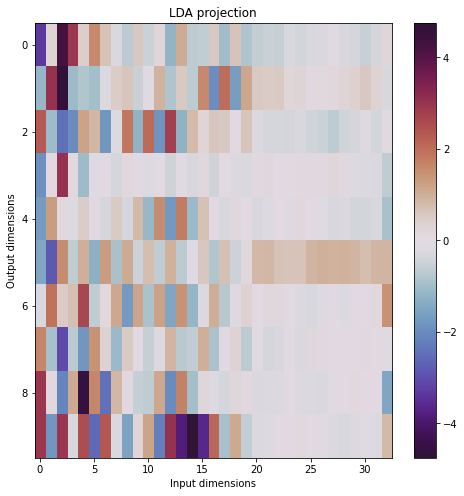

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
model = clf.steps[1][1]
weights = model.coef_

img = ax.imshow(weights, cmap='twilight_shifted', vmin=-np.abs(weights).max(), vmax=np.abs(weights).max(), aspect='auto', interpolation='none')
fig.colorbar(img, ax=ax)
ax.grid(False)
ax.set(xlabel='Input dimensions', ylabel='Output dimensions', title='LDA projection');

Remember that the first 20 dimensions correspond to MFCCs, and the last 12 correspond to chroma features.
From this visualization, we can see that most of the action is on the MFCC features, and relatively little weight is assigned to the chroma features.
This is probably what we should expect (or hope for), since chroma features are intended to be invariant to timbre, and the same notes are played by the different instruments in our training data.

---
# Neighborhood Components Analysis (NCA)

The next method that we'll test is NCA (Goldberger, Hinton, Roweis 2005).

NCA is quite different from the LDA method above, though they both learn linear projections from class labels.
Rather than try to minimize within-class variance, NCA seeks to maximize the likelihood that a "randomly selected neighbor" has the correct label.
The probability of selecting a neighbor $x_j$ for a given point $x_i$ ($i \neq j$) is:

$$
P[x_j | x_i] = \frac{\exp(-\|Mx_i - Mx_j\|^2)}{\sum_{k\neq i} \exp(-\|Mx_i - Mx_k\|^2)}
$$

If the distance is small, then probability of being selected goes up.  But we don't need *all* similarly labeled examples to be close, just enough such that the probability of getting an example with the correct label is high.

Just like before, we'll put NCA in a pipeline and fit the model.

[Pipeline] .... (step 1 of 3) Processing standardscaler, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing nca, total=  33.4s
[Pipeline]  (step 3 of 3) Processing kneighborsclassifier, total=   0.0s
              precision    recall  f1-score   support

        bass       0.75      0.90      0.82        20
       brass       0.89      0.85      0.87        20
       flute       0.77      0.50      0.61        20
      guitar       0.72      0.65      0.68        20
    keyboard       0.79      0.55      0.65        20
      mallet       0.91      1.00      0.95        20
       organ       0.93      0.70      0.80        20
        reed       0.50      0.65      0.57        20
      string       0.74      1.00      0.85        20
       vocal       0.91      1.00      0.95        20

    accuracy                           0.78       200
   macro avg       0.79      0.78      0.77       200
weighted avg       0.79      0.78      0.77       200



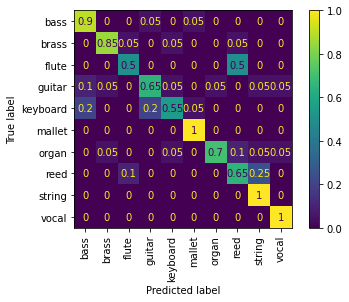

In [18]:
clf = make_pipeline(StandardScaler(), NCA(random_state=RNG_STATE), KNeighborsClassifier(n_neighbors=1), verbose=True)
clf.fit(X_train, y=y_train)

y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

plot_confusion_matrix(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

Comparing to LDA, we can see that the NCA method does a bit better on average, and substantially improves in a few categories.

Let's visualize the learned transformation.

In [19]:
reducer = umap.UMAP(random_state=RNG_STATE)

embed = reducer.fit_transform(clf[:-1].transform(X_train))
embed_test = reducer.transform(clf[:-1].transform(X_test))

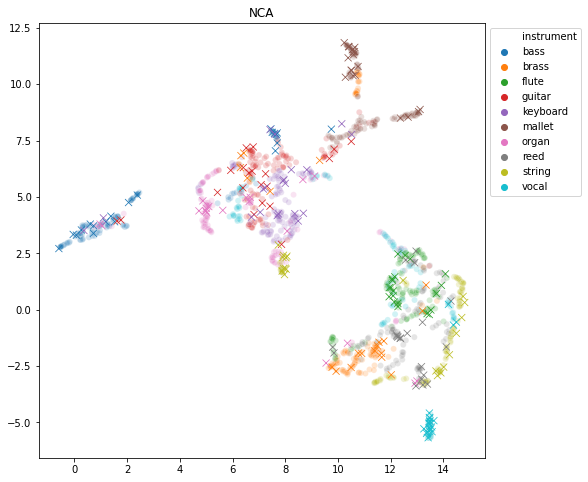

In [20]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=Y_train_raw, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=Y_test_raw, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='NCA');

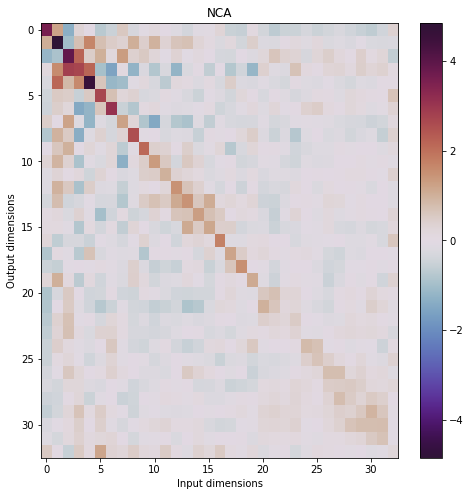

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))
model = clf.steps[1][1]
weights = model.components_

img = ax.imshow(weights, cmap='twilight_shifted', vmin=-np.abs(weights).max(), vmax=np.abs(weights).max(), aspect='auto')
fig.colorbar(img, ax=ax)
ax.grid(False)
ax.set(xlabel='Input dimensions', ylabel='Output dimensions', title='NCA');

Although the classification scores are only slightly better than LDA, we can see that the transformation learned by NCA is quite different.
Unlike LDA, the NCA solution uses the full dimensionality of the space.
Neither solution places much emphasis on the trailing dimensions (chroma and $f_0$), but they each use the MFCC content in different ways.

---
## Large-margin Nearest Neighbor (LMNN)

The final method we'll demonstrate is LMNN (Weinberger, Blitzer, and Saul 2006).

As mentioned in the tutorial, this method tries to make similarly labeled nearest neighbors closer than dissimilarly neighbors by at least a margin.

This method can be more computationally intensive than the previous methods we've seen.
However, it is also more flexible than the previous methods, and often performs well in settings where the classes are not linearly separable.

The LMNN implementation provided by the `metric_learn` package can be initialized directly with a principal components analysis (PCA) solution, which will first attempt to standardize and decorrelate the input features before learning directions which separate classes.
Since this subsumes the standardization we had been using previously, we'll skip that step and provide the raw features to LMNN instead.

[Pipeline] .............. (step 1 of 2) Processing lmnn, total=  53.2s
[Pipeline]  (step 2 of 2) Processing kneighborsclassifier, total=   0.0s
              precision    recall  f1-score   support

        bass       0.84      0.80      0.82        20
       brass       0.89      0.80      0.84        20
       flute       0.81      0.65      0.72        20
      guitar       0.56      0.70      0.62        20
    keyboard       0.81      0.65      0.72        20
      mallet       0.82      0.90      0.86        20
       organ       1.00      0.70      0.82        20
        reed       0.63      0.60      0.62        20
      string       0.76      0.95      0.84        20
       vocal       0.77      1.00      0.87        20

    accuracy                           0.78       200
   macro avg       0.79      0.78      0.77       200
weighted avg       0.79      0.78      0.77       200



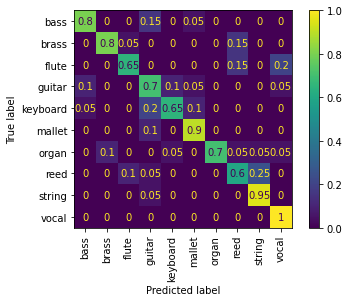

In [110]:
clf = make_pipeline(LMNN(random_state=RNG_STATE, init='pca'), KNeighborsClassifier(n_neighbors=1), verbose=True)
clf.fit(X_train, y=y_train)

y_pred = clf.predict(X_test)

report = classification_report(y_test, y_pred, target_names=encoder.classes_)

print(report)

plot_confusion_matrix(clf, X_test, y_test, display_labels=encoder.classes_, xticks_rotation='vertical', normalize='true');

In [111]:
reducer = umap.UMAP(random_state=RNG_STATE)

embed = reducer.fit_transform(clf[:-1].transform(X_train))
embed_test = reducer.transform(clf[:-1].transform(X_test))

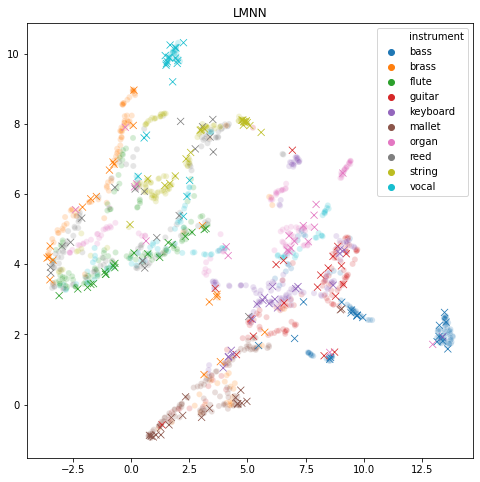

In [112]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(x=embed[:, 0], y=embed[:, 1], hue=Y_train_raw, marker='o', alpha=0.2, legend=None, ax=ax)
sns.scatterplot(x=embed_test[:, 0], y=embed_test[:, 1], hue=Y_test_raw, marker='x', s=50, alpha=1, legend='brief', ax=ax)
ax.legend(bbox_to_anchor=(1, 1));
ax.set(title='LMNN');

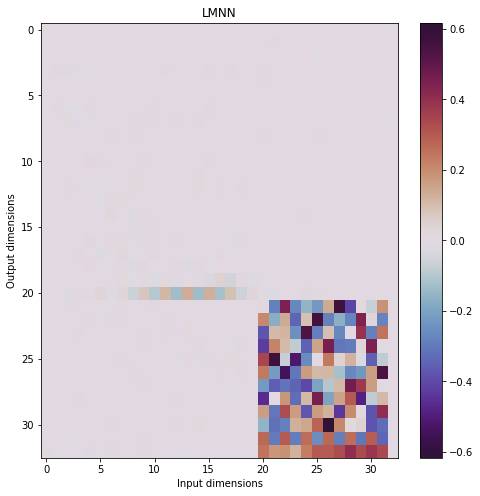

In [113]:
fig, ax = plt.subplots(figsize=(8, 8))
model = clf.steps[-2][1]
weights = model.components_

img = ax.imshow(weights, cmap='twilight_shifted', vmin=-np.abs(weights).max(), vmax=np.abs(weights).max(), aspect='auto')
fig.colorbar(img, ax=ax)
ax.grid(False)
ax.set(xlabel='Input dimensions', ylabel='Output dimensions', title='LMNN');

---
# Summary

This demonstration only scratches the surface of what's possible with these methods, but it should give you a good starting point for future experimentation.
While the remainder of this tutorial will focus on deep learning methods, it's still a good idea to have an understanding of the earlier linear methods.

## Things to try next

The `metric_learn` package implements quite a few methods that we did not cover here.
If you want to try them out, we recommend *Information-Theoretic Metric Learning* (ITML; Davis et al., 2007) as a next step.
It is implemented by the [`ITML_Supervised`](http://contrib.scikit-learn.org/metric-learn/generated/metric_learn.ITML_Supervised.html) class.

In addition to trying different methods, we also recommend experimenting with the *hyper-parameters* of the methods we've seen.
Both NCA and LMNN allow you to specify the dimensionality (number of output components), which can influence the quality of the solution.
Additionally, LMNN allows you to set the number of target neighbors and regularization penalty.
The demonstrations here used the default settings, which may not be optimal for any specific application, but could be optimized by tuning to maximize accuracy on a held-out (validation) set.

## Common pitfalls and tips

Metric learning algorithms can be sensitive to the absolute scale of the input data, especially when it comes to determining whether the learning algorithm has converged.
This is because many of them rely on relative comparisons between distances, e.g. in the neighbor selection probability of NCA or the margin constraints of LMNN.
When the input data has features on vastly different scales, some of these calculations can become unstable, and cause the learning algorithm to stop too early.
Most often, this can be resolved by standardizing the input features prior to applying the metric learning algorithm, as we've done throughout this notebook.
If you see your learning algorithm terminating too quickly and producing low accuracy, feature scale would be the first thing to check.

On the opposite end of the spectrum, it's also often useful to run the learning algorithm with `verbose=True`.
This can reveal if the solver is actually converging properly, or terminating due to reaching its maximum iteration count.
If the latter case, you may want to experiment with changing the learning rate parameter, or trying different feature normalization strategies (e.g., PCA whitening instead of `StandardScaler`).

Finally, it's always a good idea to try the simplest method first!
The order of methods presented in this tutorial is intentionally suggestive: we started with the simpler methods that make strong assumptions about the data (e.g., LDA), and then moved on to successively more complex methods.
This is general advice in machine learning, but it bears repeating: only try the complex methods after verifying that the simple methods are insufficient.